# Machine Learning 2 - Semester Project
# Garbage Classification
Linus Zarse 

***
# Project Setup

## Problem Setting

- In the domain of waste management, a paramount challenge presents itself in the precise categorization of waste materials. The complexity is increased when it comes to differentiating between waste classes that have a high visual and material similarity, such as differentiating between hard plastics and metals. This project aims to manage these nuances and implement an efficient sorting mechanism

### Project Plan
1.  Data exploration: Viewing and analysing the data.
2. Data augmentation: artificial modification of the data set.
3. Weight calculation: Adjustment for unbalanced data sets.
4. Implementation of CNNs: building and training the network architectures of self-trained and pre-trained models
5. Evaluation protocol: Application of cross-validation, significance testing and assessment using a test set.
6.cision and future steps: Selection of the best model and planning for further developments

### Models

* 6 models with 3 self-trained and 3 pre-trained 
* Pre-trained models
    * ResNet
    * VGG16 - Transfer Learning
    * VGG16 - Fine Tuning
* Self-Train:
    * CNN2
    * CNN3
    * Hyperparameter Model (Bayesiaon Optimization)


### Evaluation Protocoll
* I split the dataset intro 3 (4 Sets) Train, Validation, Test  
* Cross Validation
    * 10 – Fold Cross Validation with 10 Epochs of Training in a trainings set of 3000 Picture which contained in the Training Set (for the metrics: accuracy, precision, recall, f1)
* Statistical Evaluation
    * Performed Sign-Test and Confidence Interval calculation based on the results of the cross-validation metrices
* Holdout Testing

### Model comparision

* Comarision based on different result of the evaluation protoco

## Library Setup

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Libraries for Images
import os
import json
import glob
from PIL import Image
from itertools import combinations

# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import BayesianOptimization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


#ResNET
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Statistical Test
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score
from scipy.stats import binom

#Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from scipy.stats import binom

#Model Visualization
from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model

#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from itertools import combinations

from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model

#Own functions
import sys
from Own_Functions.k_fold_utils import k_fold_cross_validation
from Own_Functions.compare_models import compare_models
from Own_Functions.compare_model_performance import compare_model_performance
from Own_Functions.check_compile import check_compile
from Own_Functions.count_images_in_subfolders import count_images_in_subfolders
from Own_Functions.evaluate_model import evaluate_model
from Own_Functions.save_results_to_json import save_results_to_json
from Own_Functions.save_history_to_json import save_history_to_json
from Own_Functions.subgenerator_utils import create_subgenerator 
from Own_Functions.plot_metric_across_folds import plot_metric_across_folds 
from Own_Functions.plot_comparison_across_folds import plot_comparison_across_folds 
from Own_Functions.load_results_from_json import load_results_from_json
from Own_Functions.compare_models_extended import compare_models 
from Own_Functions.perform_and_compare_t_test import perform_and_compare_t_test 
from Own_Functions.sign_test import sign_test 
from Own_Functions.sign_test_table import sign_test_table 
from Own_Functions.k_fold_parallel_utils import k_fold_cross_validation_parallel

## Data and Image Exploration

In [2]:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [3]:
image_overview['Number_Images'].sum()

15515

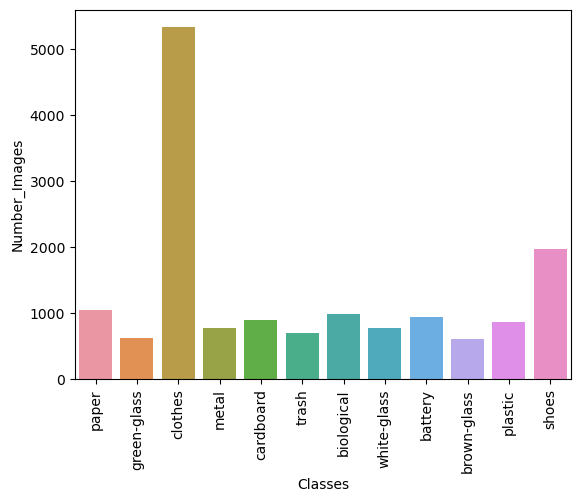

In [4]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

## Data/ Image Loading and Data Augmentation

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator


root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

file_paths = []
labels = []

# Durchlaufen aller Unterverzeichnisse 
for class_name in os.listdir(root_folder_path):
    class_dir = os.path.join(root_folder_path, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_name, file_name))
            labels.append(class_name)

# Umwandlung der Listen in Arrays 
file_paths = np.array(file_paths)
labels = np.array(labels)

# Aufteilen der Daten in Training+Validierung und Test
file_paths_train_val, file_paths_test, labels_train_val, labels_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Aufteilen der Trainings- und Validierungsdaten
file_paths_train, file_paths_val, labels_train, labels_val = train_test_split(
    file_paths_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

# Erstellen eines DataFrames für das Training
df_train = pd.DataFrame({'filepath': file_paths_train, 'label': labels_train})

# StratifiedShuffleSplit zur Erstellung eines Subsets mit 3000 Bildern
sss = StratifiedShuffleSplit(n_splits=1, test_size=3000, random_state=42)
for _, subset_index in sss.split(df_train['filepath'], df_train['label']):
    df_subset = df_train.iloc[subset_index]

# Initialisieren des ImageDataGenerator für das Training mit Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Erstellen des Trainingsdatengenerators für das vollständige Trainingset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstellen des Trainingsdatengenerators für das Subset für Cross-Validation
train_cross_validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_subset,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Für Validierung und Test ohne Augmentierung, nur Reskalierung
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Validierungsdatengenerator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': file_paths_val, 'label': labels_val}),
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Testdatengenerator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': file_paths_test, 'label': labels_test}),
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Wichtig, um die Reihenfolge bei der Bewertung zu erhalten
)

Found 9309 validated image filenames belonging to 12 classes.
Found 3000 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


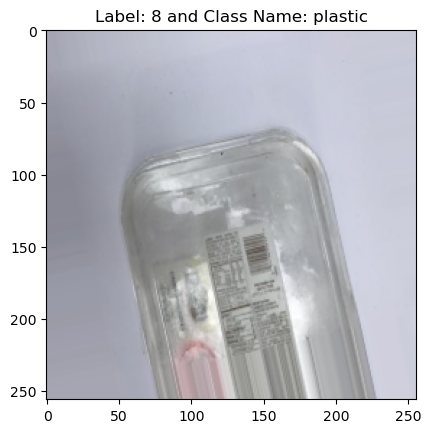

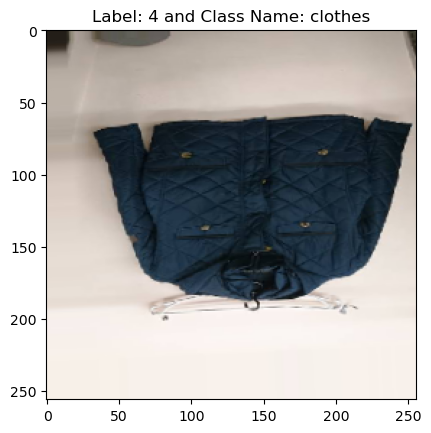

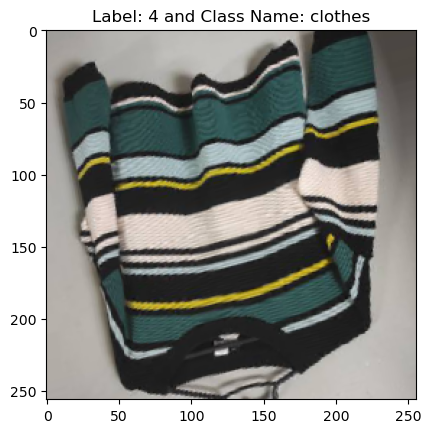

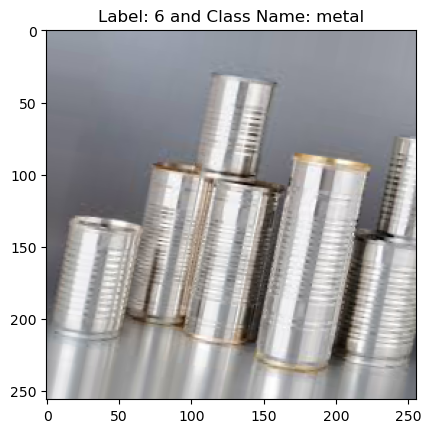

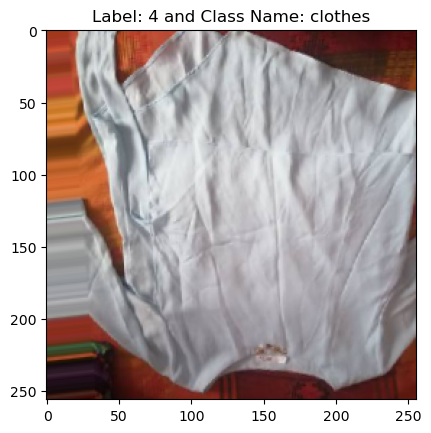

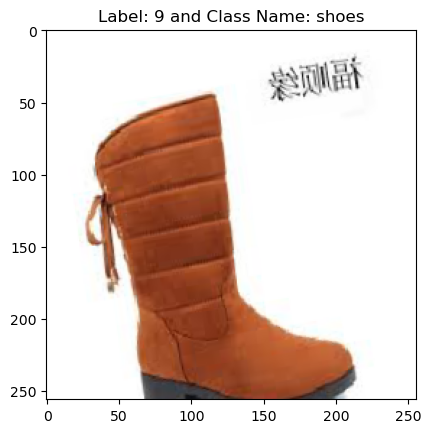

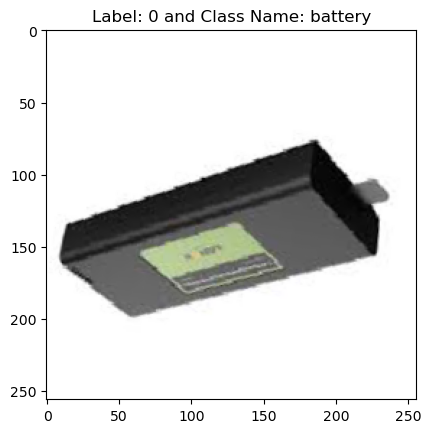

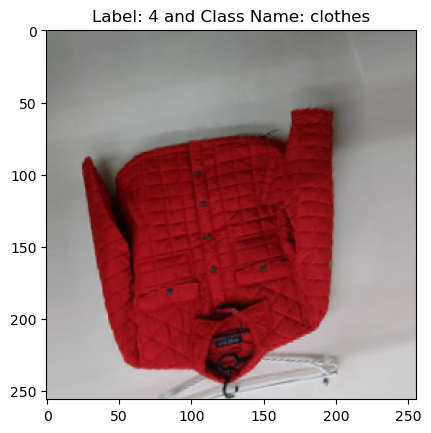

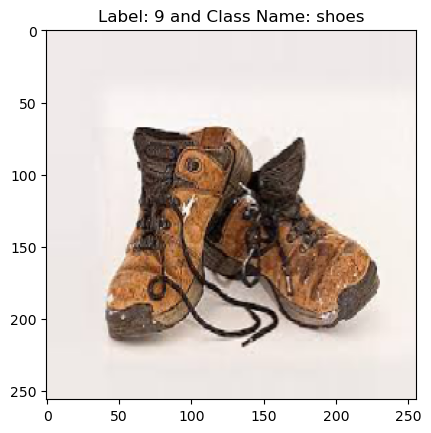

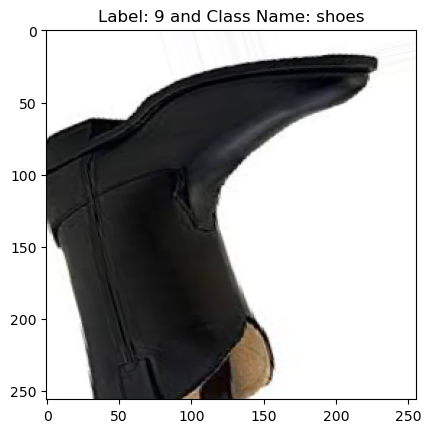

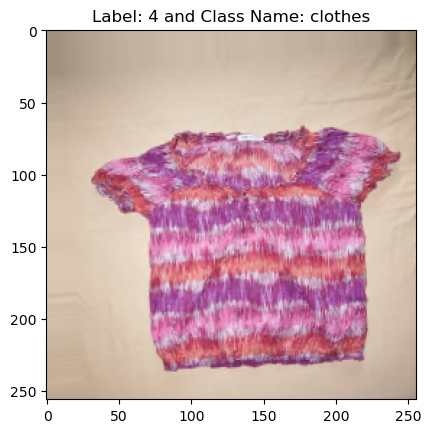

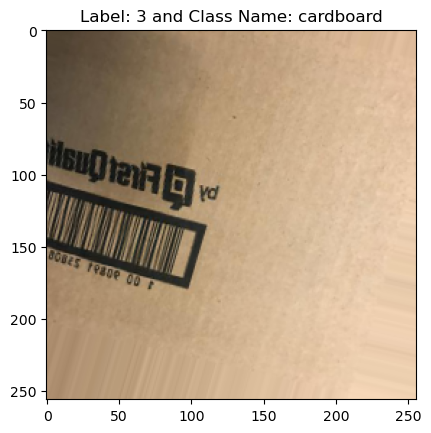

In [6]:
# Get a batch from the training generator
class_names = list(train_generator.class_indices.keys())
batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 12
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    class_name = class_names[label_index]
    
    plt.imshow(image)
    plt.title(f"Label: {label_index} and Class Name: {class_name}")
    plt.show()

***
# Implementing CNN - own build

In [7]:
# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.")

No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.


In [8]:
trainingsepochs = 50

***
## Calculate weights for unbalanced classes

In [141]:
y_integers = np.array(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class_indices = train_generator.class_indices  
class_weights_dict

class_weights_by_name = {class_name: class_weights_dict[class_index] for class_name, class_index in class_indices.items()}
class_weights_by_name

{'battery': 1.3681657848324515,
 'biological': 1.3126057529610828,
 'brown-glass': 2.131181318681319,
 'cardboard': 1.45,
 'clothes': 0.24280125195618155,
 'green-glass': 2.0576923076923075,
 'metal': 1.6827548806941433,
 'paper': 1.2313492063492064,
 'plastic': 1.4947013487475915,
 'shoes': 0.6540893760539629,
 'trash': 1.8514319809069213,
 'white-glass': 1.668279569892473}

In [10]:

num_classes = len(train_generator.class_indices)

## CNN2 - max pooling, relu, batch normalization, dropout, 

In [56]:
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename = 'best_model_cnn2.keras'
checkpoint_path = os.path.join(model_path, model_filename)

# Check if the model exists
if os.path.exists(checkpoint_path):
    # Load the model
    model_cnn2 = load_model(checkpoint_path)
    print("Modell erfolgreich geladen.")
else:
    # Define the model
    model_cnn2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    #Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model_cnn2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_cnn2.summary()
    
    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    start_time_cnn2 = time.time()
    # Train the model
    history_cnn2 = model_cnn2.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )
    
    training_time_cnn2 = time.time() - start_time_cnn2
    print(f"Trainingszeit: {training_time_cnn2} Sekunden")

Modell erfolgreich geladen.


In [12]:
# Pfad und Dateiname für die Historie
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_cnn2 = 'best_model_cnn2_training_history.json'

save_history_to_json(history_cnn2 if 'history_cnn2' in locals() else None, history_filename_cnn2, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/best_model_cnn2_training_history.json.


In [13]:
check_compile(model_cnn2)

Alright. Model is already compiled and trained


In [14]:
with open(os.path.join(model_path, history_filename_cnn2), 'r') as file:
    loaded_history = json.load(file)   

In [145]:
model_cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

## CNN3 - max pooling, stride=1, relu

In [15]:
# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename = 'best_model_cnn3.keras'
checkpoint_path = os.path.join(model_path, model_filename)

# Check if the model exists
if os.path.exists(checkpoint_path):
    # Load the model
    model_cnn3 = load_model(checkpoint_path)
    print("Modell erfolgreich geladen.")
else:
    model_cnn3 = tf.keras.models.Sequential([
    Conv2D(32 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = num_classes, activation='softmax')  
])

    # Compile the model
    model_cnn3.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_cnn3.summary()
    
    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    start_time_cnn3 = time.time()
    # Train the model
    history_cnn3 = model_cnn3.fit(
        train_generator,
        epochs=trainingsepochs,  
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )

    training_time_cnn3 = time.time() - start_time_cnn3
    print(f"Trainingszeit: {training_time_cnn3} Sekunden")

Modell erfolgreich geladen.


In [16]:
check_compile(model_cnn3)

Alright. Model is already compiled and trained


In [17]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_cnn3 = 'best_model_cnn3_training_history.json'

save_history_to_json(history_cnn3 if 'history_cnn3' in locals() else None, history_filename_cnn3, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/best_model_cnn3_training_history.json.


In [18]:
# Speichern der Daten in einer JSON-Datei
with open(os.path.join(model_path, history_filename_cnn3), 'r') as file:
    loaded_history = json.load(file)

In [144]:
model_cnn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

***
## Hyperparameter Tuning Model

In [19]:
trainingsepochs_hp=25 #because too long running time

In [21]:
def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Tuning the number and size of convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'filters_{i}', 32, 128, 32), (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Tuning the number and size of dense layers
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(hp.Int(f'units_{i}', 128, 512, 128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, 0.1)))
        # Adding L1/L2 regularizatio n
        model.add(Dense(units=hp.Int(f'units_{i}', 128, 512, 128), 
                        activation='relu', 
                        kernel_regularizer=l1_l2(l1=hp.Float('l1', 1e-5, 1e-2, sampling='LOG', default=1e-5), 
                                                 l2=hp.Float('l2', 1e-5, 1e-2, sampling='LOG', default=1e-4))))

    model.add(Dense(num_classes, activation='softmax'))

    # Tuning the learning rate
    hp_lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [22]:
tuner_dir = 'bayesian_optimization/garbage_classification'
model_path = 'best_models/hyperparameter_model.keras'
history_path = 'best_models'  # Verzeichnis, in dem die Historie gespeichert wird
history_filename_hp = 'best_model_hp_model_training_history.json'

# Überprüfen, ob das beste Modell bereits existiert
if os.path.exists(model_path):
    print("Bestes Modell wird geladen...")
    hyperparameter_model = load_model(model_path)
    print("Bestes Modell erfolgreich geladen.")
else:
    print("Kein vortrainiertes Modell gefunden. Starte den Hyperparameter-Tuning-Prozess.")
    tuner = BayesianOptimization(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        num_initial_points=4,
        directory=tuner_dir,
        project_name='garbage_classification'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    start_time_hp = time.time()

    tuner.search(train_generator,
                 epochs=trainingsepochs_hp,
                 validation_data=validation_generator,
                 callbacks=[early_stopping],
                 class_weight=class_weights_dict)

    training_time_hp = time.time() - start_time_hp
    print(f"Trainingszeit: {training_time_hp} Sekunden")

    # Hole das beste Modell
    best_model = tuner.get_best_models(num_models=1)[0]

    # Speichere das beste Modell
    print("Speichere das beste Modell...")
    best_model.save(model_path)
    print(f"Bestes Modell gespeichert unter: {model_path}")

    # Extrahiere und speichere die Trainingshistorie des besten Trials
    best_trial_id = tuner.oracle.get_best_trials(num_trials=1)[0].trial_id
    best_trial_history = tuner.get_best_trial(best_trial_id).metrics.get_history()
    best_trial_metrics = {metric: [entry['value'] for entry in best_trial_history[metric]] for metric in best_trial_history}

    # Speichere die Trainingshistorie mit Ihrer Funktion
    save_history_to_json(best_trial_metrics, history_filename_hp, history_path)

Bestes Modell wird geladen...
Bestes Modell erfolgreich geladen.


In [23]:
hyperparameter_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 96)      27744     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 96)      384       
 chNormalization)                                                
                                                        

In [ ]:
# Define a callback to save the best model during training
history_hp = hyperparameter_model.fit(
        train_generator,
        epochs=20,  
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )

In [167]:
history_filename_hp = 'best_model_hp_model_training_history.json'

save_history_to_json(history_hp if 'history_hp' in locals() else None, history_filename_hp, history_path)

Training history saved to: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/best_model_hp_model_training_history.json


***
# Implementing Pre-Trained Models


In [27]:
trainingsepochs = 20

## Transfer Learning of VGG16

In [28]:
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_vgg16_tl = 'best_model_vgg16_tl.keras'  # Update this to your VGG16 model filename
checkpoint_path_vgg16_tl = os.path.join(model_path, model_filename_vgg16_tl)

# Check if the model exists
if os.path.exists(checkpoint_path_vgg16_tl):
    # Load the model
    model_VGG16_transfer = load_model(checkpoint_path_vgg16_tl)
    print("VGG16 transfer model successfully loaded.")
else:
    print("VGG16 transfer model not found, starting training.")
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model and add pre-trained layers
    model_VGG16_transfer = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')  
    ])

    # Compile the model
    model_VGG16_transfer.compile(optimizer=Adam(), #tf.keras.optimizers.legacy.Adam()
                                 loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_VGG16_transfer.summary()

    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path_vgg16_tl, monitor='val_loss', save_best_only=True)

    start_time_VGG16_transfer = time.time()
    
    # Train the model
    history_VGG16_transfer = model_VGG16_transfer.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        workers=6,
        class_weight=class_weights_dict
    )

    # Messung der Trainingszeit beenden
    training_time_VGG16_transfer = time.time() - start_time_VGG16_transfer
    print(f"Trainingszeit: {training_time_VGG16_transfer} Sekunden")

VGG16 transfer model successfully loaded.


In [29]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_VGG16tl = 'VGG16_transfer_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_VGG16_transfer if 'history_VGG16_transfer' in locals() else None, history_filename_VGG16tl, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/VGG16_transfer_model_training_history.json.


In [30]:
with open(os.path.join(model_path, history_filename_VGG16tl), 'r') as file:
    loaded_history = json.load(file)

In [146]:
model_VGG16_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               8388864   
                                                                 
 dense_6 (Dense)             (None, 12)                3084      
                                                                 
Total params: 23106636 (88.14 MB)
Trainable params: 8391948 (32.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


***
## Fine Tuning of VGG16

In [31]:
#Fine Tuning
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
import tensorflow as tf

# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_ft = 'best_model_vgg16_ft.keras'
checkpoint_path_ft = os.path.join(model_path, model_filename_ft)

# Check if the model exists
if os.path.exists(checkpoint_path_ft):
    # Load the model
    vgg16_ft = load_model(checkpoint_path_ft)
    print("Modell erfolgreich geladen.")
else:
    print("Modell wird neu trainiert.")
    
    # 1. Laden des vortrainierten VGG16-Modells
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # 2. Anpassen des Models an meine Daten
    vgg16_ft = models.Sequential()
    vgg16_ft.add(base_model)  # Hinzufügen des vortrainierten Modells als Basis
    vgg16_ft.add(layers.Flatten())
    
    # Hinzufügen einiger Fully-Connected Schichten
    vgg16_ft.add(layers.Dense(256, activation='relu'))
    vgg16_ft.add(layers.Dropout(0.5))
    vgg16_ft.add(layers.Dense(num_classes, activation='softmax')) 
    
    # 3. Einfrieren aller Schichten im Basis-Modell
    base_model.trainable = False
    
    # 4. Kompilieren und Trainieren des Models
    vgg16_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path_ft, 
                                 monitor='val_loss', 
                                 save_best_only=True)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    # Trainieren des Modells mit Ihren eigenen `train_generator` und `validation_generator`
    history_initial = vgg16_ft.fit(train_generator, 
                                   validation_data=validation_generator, 
                                   epochs=trainingsepochs, 
                                   callbacks=[checkpoint])
    
    # 5. Fine-Tuning einiger Schichten des Basis-Modells
    # Auftauen der oberen Schichten des VGG16-Modells
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Kompilieren des Modells mit einer niedrigeren Lernrate
    vgg16_ft.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),  #tf.keras.optimizers.legacy.Adam
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

    start_time_VGG16_ft = time.time()

    
    # Erneutes Trainieren des Modells mit Fine-Tuning
    history_fine_tuning = vgg16_ft.fit(train_generator, 
                                       validation_data=validation_generator, 
                                       epochs=trainingsepochs, 
                                       callbacks=[checkpoint, early_stopping],
                                       workers=6,
                                       class_weight=class_weights_dict)
    # Messung der Trainingszeit beenden
    training_time_VGG16_ft = time.time() - start_time_VGG16_ft
    print(f"Trainingszeit: {training_time_VGG16_ft} Sekunden")



Modell erfolgreich geladen.


In [33]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_VGG16ft = 'VGG16_finetuning_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_fine_tuning if 'history_fine_tuning' in locals() else None, history_filename_VGG16ft, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/VGG16_finetuning_model_training_history.json.


In [32]:
# Display the model summary
vgg16_ft.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 12)                3084      
                                                                 
Total params: 23106636 (88.14 MB)
Trainable params: 15471372 (59.02 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


***
## RESNET 

In [34]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_resnet = 'best_model_resnet.keras'
checkpoint_path_resnet = os.path.join(model_path, model_filename_resnet)

# Check if the model exists
if os.path.exists(checkpoint_path_resnet):
    # Load the model
    model_resnet = load_model(checkpoint_path_resnet)
    print("ResNet model successfully loaded.")
else:
    print("ResNet model not found, starting training.")
    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model and add pre-trained layers
    model_resnet = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
    ])

    # Compile the model
    model_resnet.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_resnet.summary()

    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path_resnet, monitor='val_loss', save_best_only=True)

    start_time_resnet = time.time()
    
    # Train the model
    history_resnet = model_resnet.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        workers=6,
        class_weight=class_weights_dict
    )

    # Messung der Trainingszeit beenden
    training_time_resnet = time.time() - start_time_resnet
    print(f"Trainingszeit: {training_time_resnet} Sekunden")


ResNet model successfully loaded.


In [35]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_resnet = 'resnet_training_history.json'  # Aktualisierter Dateiname für ResNet

# Speichern der Historie
save_history_to_json(history_resnet if 'history_resnet' in locals() else None, history_filename_resnet, history_path)


Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/resnet_training_history.json.


In [147]:
 model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 24115340 (91.99 MB)
Trainable params: 527628 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
___________

***
# Evaluation Protocoll


In [36]:
epochs_cross_validations=10
number_splits = 10

***
### Evalutation Protocoll: K-Fold Cross Validation for CNN2

In [37]:
default_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/'
results_file_cnn2 = 'cnn2_model_cross_validation_results.json'
results_path_cnn2 = os.path.join(default_path, results_file_cnn2)

if os.path.exists(results_path_cnn2):
    print(f"Ergebnisse der Kreuzvalidierung für das CNN2-Modell existieren bereits unter: {results_path_cnn2}")
    results_cnn2 = load_results_from_json(results_file_cnn2)
else:
    # Hier fügst du den Code für die Kreuzvalidierung des model_cnn2 ein
    fold_performance_model_cnn2, avg_perf_model_cnn2, fold_histories_model_cnn2 = k_fold_cross_validation(model_cnn2,
                                                                                                     "model_cnn2", 
                                                                                                      train_cross_validation_generator, 
                                                                                                      n_splits=number_splits, 
                                                                                                      epochs=epochs_cross_validations)
        # Convert NumPy arrays in histories to lists
    fold_histories_lists_model2 = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_model_cnn2  # use the correct variable here
    ]
    
    results_model2  = {
        "fold_performance": fold_performance_model_cnn2,
        "average_performance": avg_perf_model_cnn2,
        "fold_histories": fold_histories_lists_model2
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_cnn2, results_model2)
    

#fange mit 20 Epochen an und gehe dann hoch auf +50

Ergebnisse der Kreuzvalidierung für das CNN2-Modell existieren bereits unter: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/cnn2_model_cross_validation_results.json


***
### Evalutation Protocoll: K-Fold Cross Validation for CNN3

In [38]:
results_file_cnn3 = 'cnn3_model_cross_validation_results.json'
results_path_cnn3 = os.path.join(default_path, results_file_cnn3)

if os.path.exists(results_path_cnn3):
    print(f"Ergebnisse der Kreuzvalidierung für das CNN3-Modell existieren bereits unter: {results_path_cnn3}")
    results_cnn3 = load_results_from_json(results_file_cnn3)
else:
    fold_performance_model_cnn3, avg_perf_model_cnn3, fold_histories_model_cnn3 = k_fold_cross_validation(model_cnn3,
                                                                                                       "model_cnn3",   
                                                                                                      train_cross_validation_generator, 
                                                                                                      n_splits=number_splits, 
                                                                                                      epochs=epochs_cross_validations)
    fold_histories_lists_model3 = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_model_cnn3
    ]
    
    results_model3 = {
        "fold_performance": fold_performance_model_cnn3,
        "average_performance": avg_perf_model_cnn3,
        "fold_histories": fold_histories_lists_model3
    }
    
    save_results_to_json(results_file_cnn3, results_model3)


Ergebnisse der Kreuzvalidierung für das CNN3-Modell existieren bereits unter: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/cnn3_model_cross_validation_results.json


***
### Evalutation Protocoll: K-Fold Cross Validation for Hyperparameter Tuning Model

In [39]:
results_file_hyperparameter = 'hyperparameter_model_cross_validation_results.json'
results_path_hyperparameter = os.path.join(default_path, results_file_hyperparameter)

if os.path.exists(results_path_hyperparameter):
    print(f"Ergebnisse der Kreuzvalidierung für das Hyperparameter-Modell existieren bereits unter: {results_path_hyperparameter}")
    results_hyperparameter = load_results_from_json(results_file_hyperparameter)
else:
    fold_performance_hyperparameter_model, avg_perf_hyperparameter_model, fold_histories_hyperparameter_model = k_fold_cross_validation(
        hyperparameter_model,
        "hyperparameter_model",
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_hyperparameter = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_hyperparameter_model
    ]
    
    results_hyperparameter = {
        "fold_performance": fold_performance_hyperparameter_model,
        "average_performance": avg_perf_hyperparameter_model,
        "fold_histories": fold_histories_lists_hyperparameter
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_hyperparameter, results_hyperparameter)


Found 2700 validated image filenames belonging to 12 classes.
Found 300 validated image filenames belonging to 12 classes.
Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 4.1977 - accuracy: 0.5139
Epoch 1: val_loss improved from inf to 6.20217, saving model to /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/hyperparameter_model_fold_1.keras
84/84 [==============================] - 119s 1s/step - loss: 4.1977 - accuracy: 0.5139 - val_loss: 6.2022 - val_accuracy: 0.0660
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 3.2722 - accuracy: 0.6863
Epoch 2: val_loss did not improve from 6.20217
84/84 [==============================] - 90s 1s/step - loss: 3.2722 - accuracy: 0.6863 - val_loss: 6.4640 - val_accuracy: 0.0521
Epoch 3/10
84/84 [==============================] - ETA: 0s - loss: 2.6465 - accuracy: 0.7819
Epoch 3: val_loss improved from 6.20217 to 5.64223, saving model t

***
### Evalutation Protocoll: K-Fold Cross Validation for VGG16 Transfer Learning Model

In [40]:
results_file_vgg16_transfer = 'vgg16_transfer_model_cross_validation_results.json'
results_path_vgg16_transfer = os.path.join(default_path, results_file_vgg16_transfer)

if os.path.exists(results_path_vgg16_transfer):
    print(f"Ergebnisse der Kreuzvalidierung für das VGG16-Transfer-Modell existieren bereits unter: {results_path_vgg16_transfer}")
    results_vgg16_transfer = load_results_from_json(results_file_vgg16_transfer)
else:
    fold_performance_vgg16_transfer, avg_perf_vgg16_transfer, fold_histories_vgg16_transfer = k_fold_cross_validation(
        model_VGG16_transfer,
        "model_VGG16_transfer",
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_vgg16_transfer = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_vgg16_transfer
    ]
    
    results_vgg16_transfer = {
        "fold_performance": fold_performance_vgg16_transfer,
        "average_performance": avg_perf_vgg16_transfer,
        "fold_histories": fold_histories_lists_vgg16_transfer
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_vgg16_transfer, results_vgg16_transfer)


Found 2700 validated image filenames belonging to 12 classes.
Found 300 validated image filenames belonging to 12 classes.
Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 2.2449 - accuracy: 0.3385
Epoch 1: val_loss improved from inf to 2.15350, saving model to /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/model_VGG16_transfer_fold_1.keras
84/84 [==============================] - 388s 5s/step - loss: 2.2449 - accuracy: 0.3385 - val_loss: 2.1535 - val_accuracy: 0.3611
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 2.1412 - accuracy: 0.3415
Epoch 2: val_loss improved from 2.15350 to 2.05596, saving model to /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/model_VGG16_transfer_fold_1.keras
84/84 [==============================] - 382s 5s/step - loss: 2.1412 - accuracy: 0.3415 - val_loss: 2.0560 - 

***
### Evalutation Protocoll: K-Fold Cross Validation for VGG16 Fine Tuning Model

In [43]:
results_file_vgg16_ft = 'vgg16_ft_model_cross_validation_results.json'
results_path_vgg16_ft = os.path.join(default_path, results_file_vgg16_ft)

if os.path.exists(results_path_vgg16_ft):
    print(f"Ergebnisse der Kreuzvalidierung für das VGG16-Fine-Tuning-Modell existieren bereits unter: {results_path_vgg16_ft}")
    results_vgg16_ft = load_results_from_json(results_file_vgg16_ft)
else:
    fold_performance_vgg16_ft, avg_perf_vgg16_ft, fold_histories_vgg16_ft = k_fold_cross_validation(
        vgg16_ft,
        "model_vgg16_ft",
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_vgg16_ft = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_vgg16_ft
    ]
    
    results_vgg16_ft = {
        "fold_performance": fold_performance_vgg16_ft,
        "average_performance": avg_perf_vgg16_ft,
        "fold_histories": fold_histories_lists_vgg16_ft
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_vgg16_ft, results_vgg16_ft)


Found 2700 validated image filenames belonging to 12 classes.
Found 300 validated image filenames belonging to 12 classes.
Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 2.2410 - accuracy: 0.3355
Epoch 1: val_loss improved from inf to 1.99690, saving model to /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/model_vgg16_ft_fold_1.keras
84/84 [==============================] - 464s 5s/step - loss: 2.2410 - accuracy: 0.3355 - val_loss: 1.9969 - val_accuracy: 0.3889
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 2.0702 - accuracy: 0.3411
Epoch 2: val_loss did not improve from 1.99690
84/84 [==============================] - 446s 5s/step - loss: 2.0702 - accuracy: 0.3411 - val_loss: 2.0048 - val_accuracy: 0.3819
Epoch 3/10
84/84 [==============================] - ETA: 0s - loss: 1.9336 - accuracy: 0.3909
Epoch 3: val_loss improved from 1.99690 to 1.85141, saving model to /Us

***
### Evalutation Protocoll: K-Fold Cross Validation for ResNet Model

In [42]:
results_file_resnet = 'resnet_model_cross_validation_results.json'
results_path_resnet = os.path.join(default_path, results_file_resnet)

if os.path.exists(results_path_resnet):
    print(f"Ergebnisse der Kreuzvalidierung für das ResNet-Modell existieren bereits unter: {results_path_resnet}")
    results_resnet = load_results_from_json(results_file_resnet)
else:
    fold_performance_resnet, avg_perf_resnet, fold_histories_resnet = k_fold_cross_validation(
        model_resnet,
        "model_resnet",
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_resnet = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_resnet
    ]
    
    results_resnet = {
        "fold_performance": fold_performance_resnet,
        "average_performance": avg_perf_resnet,
        "fold_histories": fold_histories_lists_resnet
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_resnet, results_resnet)


Found 2700 validated image filenames belonging to 12 classes.
Found 300 validated image filenames belonging to 12 classes.
Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 2.3215 - accuracy: 0.3392
Epoch 1: val_loss improved from inf to 2.25445, saving model to /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/model_resnet_fold_1.keras
84/84 [==============================] - 117s 1s/step - loss: 2.3215 - accuracy: 0.3392 - val_loss: 2.2544 - val_accuracy: 0.3611
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 2.2749 - accuracy: 0.3418
Epoch 2: val_loss improved from 2.25445 to 2.23958, saving model to /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/model_resnet_fold_1.keras
84/84 [==============================] - 122s 1s/step - loss: 2.2749 - accuracy: 0.3418 - val_loss: 2.2396 - val_accuracy: 0.

***
### Berechnung der anderen Metriken

In [127]:
def evaluate_model(model, test_generator, steps):
    y_true = []
    y_pred = []
    
    # Gehe durch den Generator und sammle alle wahren Labels und Vorhersagen
    for i in range(steps):
        x, y = next(test_generator)
        y_true.extend(y)
        y_pred.extend(model.predict(x))
    
    # Konvertiere die gesammelten Labels und Vorhersagen in NumPy-Arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Finde die Klasse mit der höchsten Wahrscheinlichkeit
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Berechne die verschiedenen Metriken
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Liste der Modellnamen
model_names = [
    'hyperparameter_model', 
    'model_cnn2', 
    'model_cnn3', 
    'model_resnet', 
    'model_vgg16_ft', 
    'model_VGG16_transfer'
]

# Pfad zum Verzeichnis der Modelle
model_directory = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Checkpoint_Cross_Validation/'

# Schleife über jedes Modell
for model_name in model_names:
    all_folds_results = {}

    # Schleife über jeden Fold für das aktuelle Modell
    for fold in range(1, 11):
        model_filename = f'{model_directory}{model_name}_fold_{fold}.keras'
        model = load_model(model_filename)
        
        # Berechnen Sie die Metriken für den aktuellen Fold
        # Der Generator wird zurückgesetzt, um sicherzustellen, dass wir von vorne anfangen
        train_cross_validation_generator.reset()
        metrics = evaluate_model(model, train_cross_validation_generator, steps=len(train_cross_validation_generator))
        
        # Ergebnisse für diesen Fold speichern
        all_folds_results[f'fold_{fold}'] = metrics
    
    # Ergebnisse für das aktuelle Modell in einer separaten JSON-Datei speichern
    with open(f'{model_name}_evaluation_results.json', 'w') as json_file:
        json.dump(all_folds_results, json_file, indent=4)

# Sie können die Namen der erstellten Dateien ausgeben, um den Erfolg zu bestätigen
for model_name in model_names:
    print(f'Created JSON file for {model_name}: {model_name}_evaluation_results.json')


1/1 [==============================] - 3s 3s/step
Created JSON file for hyperparameter_model: hyperparameter_model_evaluation_results.json
Created JSON file for model_cnn2: model_cnn2_evaluation_results.json
Created JSON file for model_cnn3: model_cnn3_evaluation_results.json
Created JSON file for model_resnet: model_resnet_evaluation_results.json
Created JSON file for model_vgg16_ft: model_vgg16_ft_evaluation_results.json
Created JSON file for model_VGG16_transfer: model_VGG16_transfer_evaluation_results.json


***

# Hypothesis tests for model comparisons

In [151]:
models = [model_cnn2, model_cnn3, hyperparameter_model, model_VGG16_transfer, vgg16_ft, model_resnet]
model_names = ['model_cnn2', 'model_cnn3', 
               "hyperparameter_model", 
               "model_VGG16_transfer",
              "model_vgg16_ft", 
              "model_resnet"]

#training_times = [training_time_cnn2, training_time_cnn3, training_time_hp,training_time_VGG16_transfer,training_time_VGG16_ft, training_time_resnet]


results_model2 = load_results_from_json("cnn2_model_cross_validation_results.json", default_path)
results_model3 = load_results_from_json("cnn3_model_cross_validation_results.json", default_path)
results_hyperparameter_model = load_results_from_json("hyperparameter_model_cross_validation_results.json", default_path)

results_resnet = load_results_from_json("resnet_model_cross_validation_results.json", default_path)
results_vgg16_ft = load_results_from_json("vgg16_ft_model_cross_validation_results.json", default_path)
results_vgg16_transfer = load_results_from_json("vgg16_transfer_model_cross_validation_results.json", default_path)


accuracies_model2 = results_model2['fold_performance']
accuracies_model3 = results_model3['fold_performance']
accuracies_hyperparameter_model = results_hyperparameter_model['fold_performance']

accuracies_resnet = results_resnet['fold_performance']
accuracies_vgg16_ft = results_vgg16_ft['fold_performance']
accuracies_vgg16_transfer = results_vgg16_transfer['fold_performance']


model_accuracies = {
    'Model2': results_model2['fold_performance'],
    'Model3': results_model3['fold_performance'],
    'Hyperparameter': results_hyperparameter_model['fold_performance'],
    'ResNet': results_resnet['fold_performance'],
    'VGG16_FT': results_vgg16_ft['fold_performance'],
    'VGG16_Transfer': results_vgg16_transfer['fold_performance']
}

In [152]:
# Pfad zum Verzeichnis mit den JSON-Dateien
directory_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results'

# Liste der Modellnamen
model_files = {
    'hyperparameter_model': 'hyperparameter_model_evaluation_results.json',
    'model_VGG16_transfer': 'model_VGG16_transfer_evaluation_results.json',
    'model_vgg16_ft': 'model_vgg16_ft_evaluation_results.json',
    'model_resnet': 'model_resnet_evaluation_results.json',
    'model_cnn3': 'model_cnn3_evaluation_results.json',
    'model_cnn2': 'model_cnn2_evaluation_results.json'
}

# Extrahiere Metriken aus den Dateien
model_metrics = {}
for model_name, file_name in model_files.items():
    file_path = os.path.join(directory_path, file_name)
    with open(file_path, 'r') as file:
        data = json.load(file)
        model_metrics[model_name] = {
            'accuracy': [fold['accuracy'] for fold in data.values()],
            'precision': [fold['precision'] for fold in data.values()],
            'recall': [fold['recall'] for fold in data.values()],
            'f1': [fold['f1'] for fold in data.values()]
        }


## Confidence Intervall

- **Empirische Standardabweichung**:  
  $( s_{\hat{p}} = \sqrt{\frac{\hat{p} \cdot (1 - \hat{p})}{n}} )$

- **Konfidenzintervallgrenzen**:  
  $( \epsilon = s_{\hat{p}} \cdot z )$


- **Konfidenzintervall**:  
  $( [\hat{p} - \epsilon, \hat{p} + \epsilon] )$



In [69]:
def calculate_accuracy_confidence_interval(model, test_generator, confidence_level=0.95):
    true_labels = []
    predictions = []

    for i in range(len(test_generator)):
        X, y = test_generator[i]
        true_labels.extend(np.argmax(y, axis=1))
        preds = model.predict(X, verbose=0)
        predictions.extend(np.argmax(preds, axis=1))

    observed_accuracy = accuracy_score(true_labels, predictions)
    n_successes = observed_accuracy * len(true_labels)
    n_trials = len(true_labels)

    confidence_interval = binom.interval(confidence_level, n_trials, observed_accuracy, loc=0)
    confidence_interval_accuracy = (confidence_interval[0] / n_trials, confidence_interval[1] / n_trials)

    return confidence_interval_accuracy

In [72]:
# Liste für Konfidenzintervalle
confidence_intervals = []

# Berechnen Sie das Konfidenzintervall für jedes Modell und speichern Sie die Ergebnisse
for model in models:
    ci = calculate_accuracy_confidence_interval(model, test_generator, confidence_level=0.95)
    confidence_intervals.append(ci)

# Erstellen Sie ein DataFrame mit den Ergebnissen
results_df = pd.DataFrame({
    'Modell': model_names,
    'Konfidenzintervall Untergrenze': [ci[0] for ci in confidence_intervals],
    'Konfidenzintervall Obergrenze': [ci[1] for ci in confidence_intervals]
})

In [73]:
results_df

,Modell,Konfidenzintervall Untergrenze,Konfidenzintervall Obergrenze
0,model_cnn2,0.768933,0.797937
1,model_cnn3,0.792137,0.819852
2,hyperparameter_model,0.757976,0.787303
3,model_VGG16_transfer,0.887528,0.908798
4,model_vgg16_ft,0.906220,0.925878
5,model_resnet,0.235578,0.266194


In [153]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.utils import resample
import pandas as pd
from tensorflow.keras.models import load_model

def calculate_f1_confidence_interval(model, test_generator, confidence_level=0.95, n_bootstraps=1000):
    bootstrap_f1_scores = []

    # Extrahiere die wahren Labels und Vorhersagen für den gesamten Testgenerator
    true_labels = []
    predictions = []
    for i in range(len(test_generator)):
        X, y = test_generator[i]
        true_labels.extend(np.argmax(y, axis=1))
        preds = model.predict(X, verbose=0)
        predictions.extend(np.argmax(preds, axis=1))

    # Führe Bootstrapping durch, um die Verteilung des F1-Scores zu simulieren
    for _ in range(n_bootstraps):
        # Ziehe Bootstrap-Stichproben
        bootstrap_indices = resample(np.arange(len(true_labels)), replace=True)
        bootstrap_true = np.array(true_labels)[bootstrap_indices]
        bootstrap_pred = np.array(predictions)[bootstrap_indices]

        # Berechne den F1-Score für die Bootstrap-Stichprobe
        bootstrap_f1 = f1_score(bootstrap_true, bootstrap_pred, average='macro')
        bootstrap_f1_scores.append(bootstrap_f1)

    # Berechne das Konfidenzintervall aus der Bootstrap-Verteilung
    lower_bound = np.percentile(bootstrap_f1_scores, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_f1_scores, (1 + confidence_level) / 2 * 100)

    return lower_bound, upper_bound

confidence_intervals = []

# Berechnen Sie das Konfidenzintervall für jedes Modell und speichern Sie die Ergebnisse
for model in models:
    ci = calculate_f1_confidence_interval(model, test_generator, confidence_level=0.95)
    confidence_intervals.append(ci)

# Erstellen Sie ein DataFrame mit den Ergebnissen
results_df_f1 = pd.DataFrame({
    'Modell': model_names,
    'Konfidenzintervall Untergrenze': [ci[0] for ci in confidence_intervals],
    'Konfidenzintervall Obergrenze': [ci[1] for ci in confidence_intervals]
})


In [154]:
results_df_f1

,Modell,Konfidenzintervall Untergrenze,Konfidenzintervall Obergrenze
0,model_cnn2,0.737749,0.770538
1,model_cnn3,0.756302,0.788767
2,hyperparameter_model,0.717511,0.753006
3,model_VGG16_transfer,0.842098,0.871365
4,model_vgg16_ft,0.865154,0.892454
5,model_resnet,0.214575,0.245150


***
## Sign Test for K-Fold Cross Validation

- **Nullhypothese ($H_0$)**:  
  $H_0: \text{There is no difference between the two models}$

- **Alternativhypothese ($H_1$)**:  
  $H_1: \text{There is a difference between the two models.}$

- **Sign-Test Formel**:  
  $ p = 2(1 - \text{BinCDF}_{0.5,m}(T-1)) $


In [81]:
model_accuracies = {
    'Model2': accuracies_model2,
    'Model3': accuracies_model3,
    'Hyperparameter': accuracies_hyperparameter_model,
    'ResNet': accuracies_resnet,
    'VGG16_FT': accuracies_vgg16_ft,
    'VGG16_Transfer': accuracies_vgg16_transfer
}

sign_test_results = []

for (model1, acc1), (model2, acc2) in combinations(model_accuracies.items(), 2):
    p_value, reject_null, better_alg = sign_test_table(model1, acc1, model2, acc2)
    # Rest des Codes...
    sign_test_results.append({
        'Model1': model1,
        'Model2': model2,
        'P_Value': p_value,
        'Reject_Null': reject_null,
        'Better_Model': better_alg if reject_null else 'No significant difference',
        'Better_Model_Ignoring_Significance': better_alg
    })

wins_count_significant = {model: 0 for model in model_accuracies.keys()}
wins_count_total = {model: 0 for model in model_accuracies.keys()}

for result in sign_test_results:
    if result['Reject_Null']:
        wins_count_significant[result['Better_Model']] += 1
    # Zähle hier die Gewinne, ohne die Signifikanz zu berücksichtigen
    if result['Better_Model_Ignoring_Significance'] and result['Better_Model_Ignoring_Significance'] != 'No significant difference':
        wins_count_total[result['Better_Model_Ignoring_Significance']] += 1
        

ranking_significant = pd.DataFrame(list(wins_count_significant.items()), columns=['Model', 'Wins_Significant']).sort_values('Wins_Significant', ascending=False)
ranking_significant['Rank_Significant'] = ranking_significant['Wins_Significant'].rank(ascending=False, method='dense')

ranking_total = pd.DataFrame(list(wins_count_total.items()), columns=['Model', 'Wins_Total']).sort_values('Wins_Total', ascending=False)
ranking_total['Rank_Total'] = ranking_total['Wins_Total'].rank(ascending=False, method='dense')

# Erstelle das Ergebnis-DataFrame
df_results = pd.DataFrame(sign_test_results)

# Füge die Ranglisten in das Ergebnis-DataFrame ein
df_final = pd.merge(df_results, ranking_significant, left_on='Model1', right_on='Model', how='left')
df_final = pd.merge(df_final, ranking_total, left_on='Model1', right_on='Model', how='left')

# Wähle die relevanten Spalten aus und sortiere nach den signifikanten Rängen
df_final = df_final[['Model1', 'Model2', 'P_Value', 'Reject_Null', 'Better_Model', 'Wins_Significant', 'Rank_Significant', 'Wins_Total', 'Rank_Total']]
df_final_sorted = df_final.sort_values(by='Rank_Significant', ascending=True)

ranking_significant = pd.DataFrame(list(wins_count_significant.items()), columns=['Model', 'Wins_Significant'])
ranking_significant['Rank_Significant'] = ranking_significant['Wins_Significant'].rank(ascending=False, method='dense')

# Erstelle die aggregierte Tabelle für die Gesamtanzahl der Gewinne
ranking_total = pd.DataFrame(list(wins_count_total.items()), columns=['Model', 'Wins_Total'])
ranking_total['Rank_Total'] = ranking_total['Wins_Total'].rank(ascending=False, method='dense')

# Zusammenführen der beiden aggregierten Tabellen
df_aggregated_results = pd.merge(ranking_significant, ranking_total, on='Model')
df_detailed_results = pd.DataFrame(sign_test_results)

In [82]:
df_detailed_results

,Model1,Model2,P_Value,Reject_Null,Better_Model,Better_Model_Ignoring_Significance
0,Model2,Model3,0.021484,True,Model3,Model3
1,Model2,Hyperparameter,0.001953,True,Hyperparameter,Hyperparameter
2,Model2,ResNet,0.001953,True,Model2,Model2
3,Model2,VGG16_FT,0.021484,True,Model2,Model2
4,Model2,VGG16_Transfer,0.001953,True,Model2,Model2
5,Model3,Hyperparameter,0.001953,True,Hyperparameter,Hyperparameter
6,Model3,ResNet,0.001953,True,Model3,Model3
7,Model3,VGG16_FT,0.001953,True,Model3,Model3
8,Model3,VGG16_Transfer,0.001953,True,Model3,Model3
9,Hyperparameter,ResNet,0.001953,True,Hyperparameter,Hyperparameter


In [83]:
df_aggregated_results.sort_values(by='Rank_Total')

,Model,Wins_Significant,Rank_Significant,Wins_Total,Rank_Total
2,Hyperparameter,5,1.0,5,1.0
1,Model3,4,2.0,4,2.0
0,Model2,3,3.0,3,3.0
4,VGG16_FT,1,4.0,1,4.0
5,VGG16_Transfer,1,4.0,1,4.0
3,ResNet,0,5.0,0,5.0


In [139]:
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

results_by_metric = {metric: [] for metric in metrics_to_compare}

for metric in metrics_to_compare:
    model_metrics_by_metric = {model: metrics[metric] for model, metrics in model_metrics.items()}
    
    for (model1, results1), (model2, results2) in combinations(model_metrics_by_metric.items(), 2):
        p_value, reject_null, better_alg = sign_test_table(model1, results1, model2, results2)
        
        results_by_metric[metric].append({
            'Model1': model1,
            'Model2': model2,
            'P_Value': p_value,
            'Reject_Null': reject_null,
            'Better_Model': better_alg if reject_null else 'No significant difference'
        })

df_final_by_metric = {}
for metric, results in results_by_metric.items():
    df_results = pd.DataFrame(results)
    df_final_by_metric[metric] = df_results

In [140]:
df_final_by_metric['f1']

,Model1,Model2,P_Value,Reject_Null,Better_Model
0,hyperparameter_model,model_VGG16_transfer,0.001953,True,hyperparameter_model
1,hyperparameter_model,model_vgg16_ft,0.001953,True,hyperparameter_model
2,hyperparameter_model,model_resnet,0.001953,True,hyperparameter_model
3,hyperparameter_model,model_cnn3,0.021484,True,hyperparameter_model
4,hyperparameter_model,model_cnn2,0.001953,True,hyperparameter_model
5,model_VGG16_transfer,model_vgg16_ft,0.753906,False,No significant difference
6,model_VGG16_transfer,model_resnet,0.001953,True,model_VGG16_transfer
7,model_VGG16_transfer,model_cnn3,0.001953,True,model_cnn3
8,model_VGG16_transfer,model_cnn2,0.001953,True,model_cnn2
9,model_vgg16_ft,model_resnet,0.001953,True,model_vgg16_ft


In [135]:
df_aggregated_results_by_metric = {}

for metric, df_results in df_final_by_metric.items():
    wins_count_significant = {model: 0 for model in model_metrics.keys()}
    wins_count_total = {model: 0 for model in model_metrics.keys()}

    for index, row in df_results.iterrows():
        if row['Reject_Null']:
            wins_count_significant[row['Better_Model']] += 1
        # Zähle hier die Gewinne, ohne die Signifikanz zu berücksichtigen
        if row['Better_Model'] != 'No significant difference':
            wins_count_total[row['Better_Model']] += 1
    
    # Erstelle Ranglisten
    ranking_significant = pd.DataFrame(list(wins_count_significant.items()), columns=['Model', 'Wins_Significant']).sort_values('Wins_Significant', ascending=False)
    ranking_significant['Rank_Significant'] = ranking_significant['Wins_Significant'].rank(ascending=False, method='dense')

    ranking_total = pd.DataFrame(list(wins_count_total.items()), columns=['Model', 'Wins_Total']).sort_values('Wins_Total', ascending=False)
    ranking_total['Rank_Total'] = ranking_total['Wins_Total'].rank(ascending=False, method='dense')
    
    # Zusammenführen der beiden aggregierten Tabellen
    df_aggregated_results = pd.merge(ranking_significant, ranking_total, on='Model')
    df_aggregated_results_by_metric[metric] = df_aggregated_results



In [138]:
df_aggregated_results_by_metric['f1']

,Model,Wins_Significant,Rank_Significant,Wins_Total,Rank_Total
0,hyperparameter_model,5,1.0,5,1.0
1,model_cnn3,3,2.0,3,2.0
2,model_cnn2,3,2.0,3,2.0
3,model_VGG16_transfer,1,3.0,1,3.0
4,model_vgg16_ft,1,3.0,1,3.0
5,model_resnet,0,4.0,0,4.0


## Evaluation on Unseen Test Set

In [77]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import time

# Definieren Sie Ihre Modelle und deren Namen
models = [model_cnn2, model_cnn3, hyperparameter_model, model_VGG16_transfer, vgg16_ft, model_resnet]
model_names = ['model_cnn2', 'model_cnn3', "hyperparameter_model", "model_VGG16_transfer", "vgg16_ft", "model_resnet"]

results = []

test_generator.reset()

# Iterieren Sie über jedes Modell, um Vorhersagen zu machen und Metriken zu berechnen
for model, name in zip(models, model_names):
    start_time = time.time()  
    true_labels, predictions, probabilities = [], [], []

    # Durchlaufen Sie den Testgenerator, ohne tqdm zu verwenden
    for i in range(len(test_generator)):
        X, y = test_generator[i]
        y_true = np.argmax(y, axis=1)
        y_pred = model.predict(X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        probabilities.extend(y_pred)  # Für ROC-AUC Berechnung
        true_labels.extend(y_true)
        predictions.extend(y_pred_classes)

    # Vorhersagezeit berechnen
    prediction_time = time.time() - start_time
    total_params = model.count_params() 

    # Metriken berechnen
    accuracy = accuracy_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, probabilities, multi_class='ovr', average='macro')
    precision = precision_score(true_labels, predictions, average='macro',  zero_division=1)
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    # Ergebnisse speichern
    results.append({
        'Modell': name,
        'Accuracy': accuracy,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Vorhersagezeit (Sekunden)': prediction_time,
        'Gesamtanzahl Parameter': total_params
    })

# Ergebnisse in einem DataFrame zusammenfassen
results_df = pd.DataFrame(results)



1/1 [==============================] - 1s 1s/step


In [103]:
results_df

,Modell,Accuracy,AUC,Precision,Recall,F1-Score,Vorhersagezeit (Sekunden),Gesamtanzahl Parameter
0,model_cnn2,0.783435,0.975473,0.743122,0.777888,0.755595,34.089122,29726412
1,model_cnn3,0.805994,0.975637,0.762112,0.788894,0.773679,24.850780,3343116
2,hyperparameter_model,0.772801,0.972231,0.734450,0.749784,0.736462,32.786672,1742124
3,model_VGG16_transfer,0.898163,0.991517,0.857004,0.860653,0.857317,426.237750,23106636
4,vgg16_ft,0.916210,0.993011,0.880104,0.880742,0.879509,429.542631,23106636
5,model_resnet,0.250725,0.762697,0.263663,0.285262,0.229945,120.192587,24115340


### Which Classes are predicted good and which not? 

In [110]:
models = [model_cnn2, model_cnn3, hyperparameter_model, model_VGG16_transfer, vgg16_ft, model_resnet]
model_names = ['model_cnn2', 'model_cnn3', "hyperparameter_model", "model_VGG16_transfer", "vgg16_ft", "model_resnet"]

dfs = {}

# Stellen Sie sicher, dass der Testgenerator zurückgesetzt wird
test_generator.reset()

# Iterieren Sie über jedes Modell, um Vorhersagen zu machen und Metriken zu berechnen
for model, name in zip(models, model_names):
    # Erhalte Vorhersagen für das aktuelle Modell
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Wahren Labels aus dem test_generator extrahieren
    true_labels = test_generator.classes  # Korrigierte Zeile

    # Berechnung der Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_classes)  # Korrigierte Zeile

    # Berechnung des Prozentsatzes der korrekten Vorhersagen für jede Klasse
    class_correct_predictions = cm.diagonal() / cm.sum(axis=1)
    class_names = list(test_generator.class_indices.keys())

    # Erstellen eines DataFrames für eine übersichtliche Darstellung
    dfs[name] = pd.DataFrame({
        'Klasse': class_names,
        'Richtige Vorhersagen': cm.diagonal(),
        'Gesamtanzahl': cm.sum(axis=1),
        'Genauigkeit (%)': class_correct_predictions * 100
    })


97/97 [==============================] - 118s 1s/step


In [111]:
models = [model_cnn2, model_cnn3, hyperparameter_model, model_VGG16_transfer, vgg16_ft, model_resnet]
model_names = ['model_cnn2', 'model_cnn3', "hyperparameter_model", "model_VGG16_transfer", "vgg16_ft", "model_resnet"]

class_accuracies = []

for model in models:
    test_generator.reset()
    predictions = []
    true_labels = []

    for _ in range(len(test_generator)):
        X, y = next(test_generator)
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(model.predict(X), axis=1)
        predictions.extend(y_pred)
        true_labels.extend(y_true)

    # Erstellen der Konfusionsmatrix für das aktuelle Modell
    cm = confusion_matrix(true_labels, predictions)
    
    # Berechnung des Prozentsatzes der korrekten Vorhersagen für jede Klasse
    class_correct_predictions = cm.diagonal() / cm.sum(axis=1)
    class_accuracies.append(class_correct_predictions)

# Erstellen eines DataFrames für eine übersichtliche Darstellung
class_accuracy_df = pd.DataFrame(class_accuracies, columns=test_generator.class_indices.keys(), index=model_names)

1/1 [==============================] - 1s 1s/step


,battery,biological,brown-glass,cardboard,clothes,green-glass,metal,paper,plastic,shoes,trash,white-glass
model_cnn2,0.693122,0.883249,0.836066,0.893258,0.823474,0.936508,0.727273,0.804762,0.618497,0.688608,0.726619,0.703226
model_cnn3,0.772487,0.847716,0.852459,0.882022,0.884507,0.896825,0.623377,0.871429,0.664740,0.645570,0.841727,0.683871
hyperparameter_model,0.751323,0.791878,0.827869,0.853933,0.847887,0.928571,0.636364,0.804762,0.433526,0.708861,0.870504,0.541935
model_VGG16_transfer,0.920635,0.964467,0.836066,0.882022,0.964319,0.904762,0.649351,0.847619,0.763006,0.939241,0.920863,0.735484
vgg16_ft,0.915344,0.994924,0.901639,0.926966,0.980282,0.936508,0.772727,0.904762,0.612717,0.959494,0.928058,0.735484
model_resnet,0.582011,0.593909,0.278689,0.117978,0.187793,0.293651,0.032468,0.485714,0.289017,0.086076,0.359712,0.116129


In [115]:
class_accuracy_df = class_accuracy_df.transpose()
class_accuracy_df

,model_cnn2,model_cnn3,hyperparameter_model,model_VGG16_transfer,vgg16_ft,model_resnet
battery,0.693122,0.772487,0.751323,0.920635,0.915344,0.582011
biological,0.883249,0.847716,0.791878,0.964467,0.994924,0.593909
brown-glass,0.836066,0.852459,0.827869,0.836066,0.901639,0.278689
cardboard,0.893258,0.882022,0.853933,0.882022,0.926966,0.117978
clothes,0.823474,0.884507,0.847887,0.964319,0.980282,0.187793
green-glass,0.936508,0.896825,0.928571,0.904762,0.936508,0.293651
metal,0.727273,0.623377,0.636364,0.649351,0.772727,0.032468
paper,0.804762,0.871429,0.804762,0.847619,0.904762,0.485714
plastic,0.618497,0.664740,0.433526,0.763006,0.612717,0.289017
shoes,0.688608,0.645570,0.708861,0.939241,0.959494,0.086076


# Discussion and Conclusion

Ranking
* VGG16_FT 
    * Very good results in every metric 
    * Very long prediction times and high number of parameters
* VGG16_TL
    * Slightly worse predictions than VGG_FT 
    * Very long prediction times and high number of parameters
* CNN_3
    * Second highest F1 score and high accuracy
    * Short prediction time
* CNN_2
* Hyperparameter Model
* RESNET


Find the best Model and Benchmarking:
* Use VGG16_FT for unlimited resources.
* Choose CNN3 as a simpler model.
* Hyperparameter_Model: A good compromise for practical applications, because of robust performance

Model Architecture: 
* Simpler models have shorter prediction times and fewer parameters
* tend to overfit less and offer greater generalizability to unknown data
* Pre-trained models utilize deep network architectures that enable extensive feature extraction and in complex tasks
 	benefit from transfer learning, which enables faster and more efficient learning

Remarks: 
* results relate to the specific context of the data set used
* Personal preference: Tendency towards more robust models due to their reliability in different use cases
